## Background

Zillow’s Zestimate home valuation has shaken up the U.S. real estate industry since first released 11 years ago.

A home is often the largest and most expensive purchase a person makes in his or her lifetime. Ensuring homeowners have a trusted way to monitor this asset is incredibly important. The Zestimate was created to give consumers as much information as possible about homes and the housing market, marking the first time consumers had access to this type of home value information at no cost.

“Zestimates” are estimated home values based on 7.5 million statistical and machine learning models that analyze hundreds of data points on each property. And, by continually improving the median margin of error (from 14% at the onset to 5% today), Zillow has since become established as one of the largest, most trusted marketplaces for real estate information in the U.S. and a leading example of impactful machine learning.

#### Objective:

Build a model to improve the Zestimate residual error. 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix,accuracy_score
import re
color = sns.color_palette()
import datetime
from catboost import CatBoostRegressor
from category_encoders import BinaryEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelBinarizer,Imputer,OneHotEncoder,LabelEncoder
#from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.datasets import dump_svmlight_file

from sklearn.cross_validation import train_test_split


%matplotlib inline

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


#### Reading the dataset

In [2]:
train=pd.read_csv('C:/Users/Lenovo/Downloads/all/train_2016_v2.csv',parse_dates=['transactiondate'])
properties=pd.read_csv('C:/Users/Lenovo/Downloads/all/properties_2016.csv')
sample=pd.read_csv('C:/Users/Lenovo/Downloads/all/sample_submission.csv')

C:\Users\Lenovo\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
for c, dtype in zip(properties.columns, properties.dtypes):
    if dtype == np.float64:
        properties[c] = properties[c].astype(np.float32)
        

def add_date_features(df):
    df["transaction_year"] = df["transactiondate"].dt.year
    df["transaction_month"] = df["transactiondate"].dt.month
    df["transaction_day"] = df["transactiondate"].dt.day
    df["transaction_quarter"] = df["transactiondate"].dt.quarter
    df.drop(["transactiondate"], inplace=True, axis=1)
    return df

#### Statistical Summary

### Data wrangling:


In [5]:
columns=[ 'airconditioningtypeid', 'architecturalstyletypeid',
       'basementsqft', 'bathroomcnt', 'bedroomcnt', 'buildingclasstypeid',
       'buildingqualitytypeid', 'calculatedbathnbr', 'decktypeid',
       'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15',
       'finishedsquarefeet50', 'finishedsquarefeet6', 'fips', 'fireplacecnt',
       'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa',
       'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet',
       'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7',
       'propertycountylandusecode', 'propertylandusetypeid',
       'propertyzoningdesc', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt',
       'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid',
       'unitcnt', 'yardbuildingsqft17', 'yardbuildingsqft26', 'yearbuilt',
       'numberofstories', 'fireplaceflag', 'structuretaxvaluedollarcnt',
       'taxvaluedollarcnt', 'assessmentyear', 'landtaxvaluedollarcnt',
       'taxamount', 'taxdelinquencyflag', 'taxdelinquencyyear',
       'censustractandblock']

In [6]:
properties.parcelid.isnull().dropna(axis=0,inplace=True)


After closely looking at the descriptions of each columns, it looks like some columns has redundant
data. we will drop those columns

In [7]:
#'bathroomcnt', 'calculatedbathnbr' have same description
properties['bathroomcnt'].isnull().sum() #----25

properties['calculatedbathnbr'].isnull().sum() #----117475

#we will drop 'calculatedbathnbr' as it has more null values
drop_cols=['calculatedbathnbr']


#'finishedfloor1squarefeet', 'finishedsquarefeet50' have same description
properties['finishedfloor1squarefeet'].isnull().sum() #----2771063

properties['finishedsquarefeet50'].isnull().sum() #----2771063

#we will drop 'calculatedbathnbr' as it has more null values
drop_cols.append('finishedsquarefeet50')



In [8]:
#FIPS:Federal Information Processing Standard code. This column is mostly redundant. So we are droping this column
properties.fips.unique()
drop_cols.append('fips')

#columns rawcensustractandblock and censustractandblock contain same information. lets retain rawcensustractandblock since it has no NaN values.
properties.rawcensustractandblock.isnull().sum()#----0

properties.censustractandblock.isnull().sum()#-----63689
drop_cols.append('censustractandblock')


In [9]:
#updating 'pooltypeid10'=1 when 'pooltypeid2'=1
properties['pooltypeid10']=np.where(properties['pooltypeid2']==1,1,0) 

#updating 'poolcnt'=1 when 'pooltypeid2'=1
properties['poolcnt']=np.where(properties['pooltypeid2']==1,1,0) 

#updating 'poolcnt'=1 when 'pooltypeid7'=1
properties['poolcnt']=np.where(properties['pooltypeid7']==1,1,0) 

#updating NaN values to 0
properties['pooltypeid7']=np.where(properties['pooltypeid7'].isnull(),0,1)

#updating NaN values to 0 
properties['pooltypeid2']=np.where(properties['pooltypeid2'].isnull(),0,1)

#If there is no pool pool size must be zero
properties['poolsizesum']=np.where(properties['poolcnt'].isnull(),0,1)

In [10]:
#updating airconditioningtypeid to 6, which is 'other' category, refering zillow data dictionary
index = properties.airconditioningtypeid.isnull()
properties.loc[index,'airconditioningtypeid'] = 6

#The below variables are flags and lets assume if they are NA's it means the object does not exist so lets fix this
index = properties.hashottuborspa.isnull()
properties.loc[index,'hashottuborspa'] = "None"

#updating airconditioningtypeid to 6, which is 'other' category, refering zillow data dictionary
index = properties.heatingorsystemtypeid.isnull()
properties.loc[index,'heatingorsystemtypeid'] = 14



#updating taxdelinquencyflag to valid flag based on the value of taxdelinquencyyear
properties['taxdelinquencyflag']=np.where(properties['taxdelinquencyyear'].isnull(),'None','True')

#updating taxdelinquencyflag to valid flag based on the value of taxdelinquencyyear
index = properties.fireplacecnt.isnull()
properties.loc[index,'fireplacecnt'] = 0

properties['fireplaceflag']=np.where(properties['fireplacecnt']==0,'None','True')

#properties['regionidzip'].isnull().sum()
#drop_cols.append('regionidzip')

In [11]:

#if 'bathroomcnt'=0 then 'fullbathcnt' and 'threequarterbathnbr' should be zero too

index = properties.bathroomcnt.isnull()
properties.loc[index,'fullbathcnt'] = 0
properties.loc[index,'threequarterbathnbr'] = 0

index = properties.roomcnt.isnull()
properties.loc[index,'roomcnt']=properties['roomcnt'].median()

In [12]:
properties.drop(columns=drop_cols,inplace=True)

In [13]:
train_merge = train.merge(properties, how='left', on='parcelid')

In [14]:
ulimit = np.percentile(train_merge.logerror.values, 99)
llimit = np.percentile(train_merge.logerror.values, 1)
train_merge['logerror'].ix[train_merge['logerror']>ulimit] = ulimit
train_merge['logerror'].ix[train_merge['logerror']<llimit] = llimit


C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


In [15]:
train_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90275 entries, 0 to 90274
Data columns (total 56 columns):
parcelid                        90275 non-null int64
logerror                        90275 non-null float64
transactiondate                 90275 non-null datetime64[ns]
airconditioningtypeid           90275 non-null float32
architecturalstyletypeid        261 non-null float32
basementsqft                    43 non-null float32
bathroomcnt                     90275 non-null float32
bedroomcnt                      90275 non-null float32
buildingclasstypeid             16 non-null float32
buildingqualitytypeid           57364 non-null float32
decktypeid                      658 non-null float32
finishedfloor1squarefeet        6856 non-null float32
calculatedfinishedsquarefeet    89614 non-null float32
finishedsquarefeet12            85596 non-null float32
finishedsquarefeet13            33 non-null float32
finishedsquarefeet15            3564 non-null float32
finishedsquarefeet6  

In [16]:
#We will drop any coulmn with more than 99% missing values.

missing_perc_thresh = 0.99
exclude_missing = []
num_rows = train_merge.shape[0]
for c in train_merge.columns:
    num_missing = train_merge[c].isnull().sum()
    if num_missing == 0:
        continue
    missing_frac = num_missing / float(num_rows)
    if missing_frac > missing_perc_thresh:
        exclude_missing.append(c)
print("We exclude: %s" % exclude_missing)
print(len(exclude_missing))

We exclude: ['architecturalstyletypeid', 'basementsqft', 'buildingclasstypeid', 'decktypeid', 'finishedsquarefeet13', 'finishedsquarefeet6', 'storytypeid', 'typeconstructiontypeid', 'yardbuildingsqft26']
9


In [17]:
# exclude where we only have one unique value 
exclude_unique = []
for c in train_merge.columns:
    num_uniques = len(train_merge[c].unique())
    if train_merge[c].isnull().sum() != 0:
        num_uniques -= 1
    if num_uniques == 1:
        exclude_unique.append(c)
print("We exclude: %s" % exclude_unique)
print(len(exclude_unique))

We exclude: ['buildingclasstypeid', 'decktypeid', 'poolsizesum', 'storytypeid', 'assessmentyear']
5


In [18]:
#Selecting categorical variables for model building.
exclude_other = ['transactiondate','propertycountylandusecode','propertyzoningdesc']
cat_feature_inds = []
col=train_merge.columns
cat_unique_thresh = 1000
for c in train_merge.columns:
     if train_merge[c].dtype == 'object' \
            and c not in exclude_other:
        cat_feature_inds.append(c)       
print("Cat features are: %s" %  cat_feature_inds)

Cat features are: ['hashottuborspa', 'fireplaceflag', 'taxdelinquencyflag']


In [19]:
# displaying unique categorical variables and thier count
for name in cat_feature_inds:
    print("Unique Values in column: {}\n".format(name))
    print(train_merge[name].value_counts(),'\n')

Unique Values in column: hashottuborspa

None    87910
True     2365
Name: hashottuborspa, dtype: int64 

Unique Values in column: fireplaceflag

None    80668
True     9607
Name: fireplaceflag, dtype: int64 

Unique Values in column: taxdelinquencyflag

None    88492
True     1783
Name: taxdelinquencyflag, dtype: int64 



### Handling Categorical Variables

In [20]:
for c in cat_feature_inds:
    dummy=pd.get_dummies(train_merge[c],prefix=c)
    train_merge=pd.concat([train_merge,dummy],axis=1)
train_merge.drop(['hashottuborspa', 'fireplaceflag', 'taxdelinquencyflag'],axis=1,inplace=True)


### Feature selection

In [21]:
exclude_other = ['parcelid', 'logerror','transactiondate','regionidcounty','latitude', 'longitude','index'] 
train_features = []
for c in train_merge.columns:
    if c not in exclude_missing \
       and c not in exclude_other \
        and c not in exclude_unique and train_merge[c].dtype != 'object':
        train_features.append(c)
print("We use these for training: %s" % train_features)
print(len(train_features))

We use these for training: ['airconditioningtypeid', 'bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid', 'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'finishedsquarefeet15', 'fireplacecnt', 'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'heatingorsystemtypeid', 'lotsizesquarefeet', 'poolcnt', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'propertylandusetypeid', 'rawcensustractandblock', 'regionidcity', 'regionidneighborhood', 'regionidzip', 'roomcnt', 'threequarterbathnbr', 'unitcnt', 'yardbuildingsqft17', 'yearbuilt', 'numberofstories', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount', 'taxdelinquencyyear', 'hashottuborspa_True', 'hashottuborspa_None', 'fireplaceflag_None', 'fireplaceflag_True', 'taxdelinquencyflag_None', 'taxdelinquencyflag_True']
40


#### Univariate Analysis:

Since there are so many variables, let us first take the 'float' variables alone and then get the correlation with the target variable to see how they are related.

C:\Users\Lenovo\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\Lenovo\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


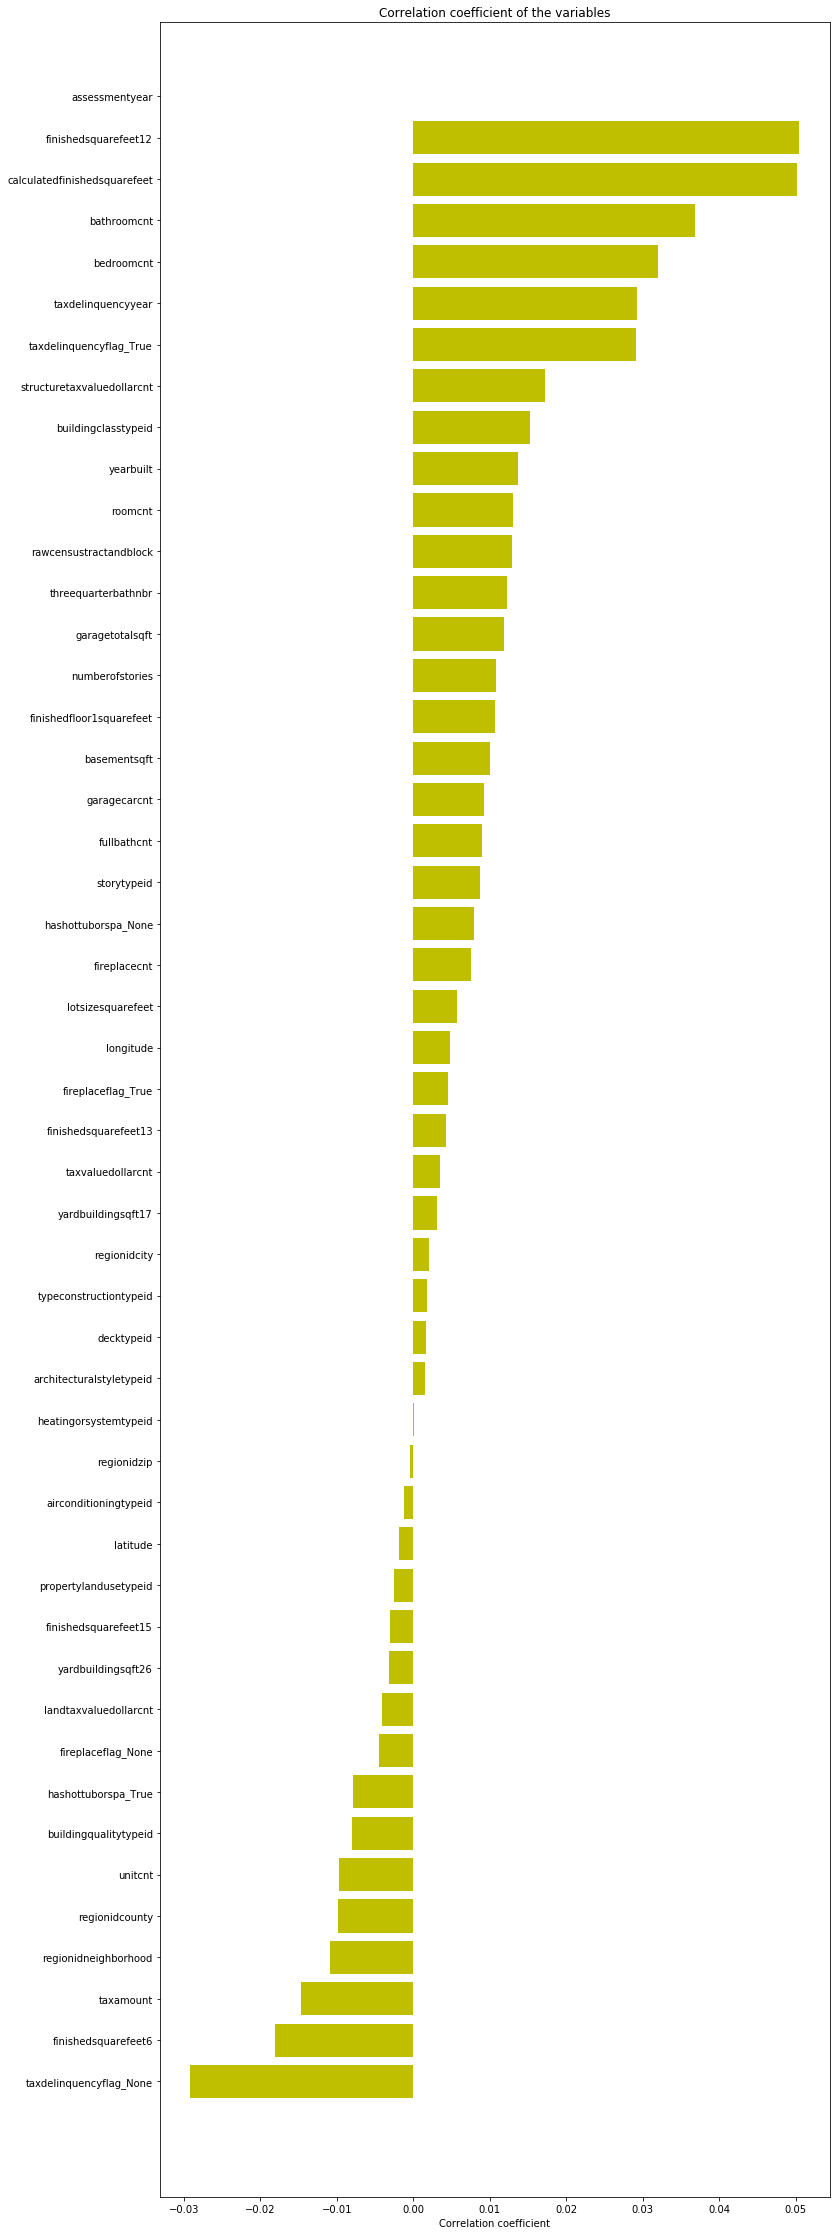

In [22]:
# Let us just impute the missing values with mean values to compute correlation coefficients #
#median_values = train_merge.median(axis=0)
#train_merge=pd.DataFrame(train_merge.fillna(median_values, inplace=True))
train_merge.fillna(-999,inplace=True)
x_cols = [col for col in train_merge.columns if col not in ['logerror']  if train_merge[col].dtype=='float32' or train_merge[col].dtype=='uint8']

labels = []
values = []
for col in x_cols:
    labels.append(col)
    values.append(np.corrcoef(train_merge[col].values, train_merge.logerror.values)[0,1])
corr_df = pd.DataFrame({'col_labels':labels, 'corr_values':values})
corr_df = corr_df.sort_values(by='corr_values')
    
ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(12,40))
rects = ax.barh(ind, np.array(corr_df.corr_values.values), color='y')
ax.set_yticks(ind)
ax.set_yticklabels(corr_df.col_labels.values, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient of the variables")
#autolabel(rects)
plt.show()

In [23]:
imp_features=corr_df.ix[(corr_df['corr_values']>0.02) | (corr_df['corr_values'] < -0.01)]
imp_features

C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


,col_labels,corr_values
47,taxdelinquencyflag_None,-0.029167
13,finishedsquarefeet6,-0.018072
41,taxamount,-0.014767
26,regionidneighborhood,-0.010854
48,taxdelinquencyflag_True,0.029167
42,taxdelinquencyyear,0.029170
4,bedroomcnt,0.032035
3,bathroomcnt,0.036862
9,calculatedfinishedsquarefeet,0.050202
10,finishedsquarefeet12,0.050434


,taxdelinquencyflag_None,finishedsquarefeet6,taxamount,regionidneighborhood,taxdelinquencyflag_True,taxdelinquencyyear,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,finishedsquarefeet12
taxdelinquencyflag_None,1.000000,0.005998,0.010250,-0.004804,-1.000000,-0.999996,0.006528,0.033279,0.021811,0.033251
finishedsquarefeet6,0.005998,1.000000,0.037074,-0.010140,-0.005998,-0.005994,-0.120686,-0.105816,0.072856,-0.153430
taxamount,0.010250,0.037074,1.000000,0.052414,-0.010250,-0.010216,0.239052,0.461889,0.561597,0.481260
regionidneighborhood,-0.004804,-0.010140,0.052414,1.000000,0.004804,0.004808,-0.061384,-0.020169,-0.016436,-0.071359
taxdelinquencyflag_True,-1.000000,-0.005998,-0.010250,0.004804,1.000000,0.999996,-0.006528,-0.033279,-0.021811,-0.033251
taxdelinquencyyear,-0.999996,-0.005994,-0.010216,0.004808,0.999996,1.000000,-0.006518,-0.033260,-0.021793,-0.033239
bedroomcnt,0.006528,-0.120686,0.239052,-0.061384,-0.006528,-0.006518,1.000000,0.646120,0.652013,0.401407
bathroomcnt,0.033279,-0.105816,0.461889,-0.020169,-0.033279,-0.033260,0.646120,1.000000,0.782058,0.589584
calculatedfinishedsquarefeet,0.021811,0.072856,0.561597,-0.016436,-0.021811,-0.021793,0.652013,0.782058,1.000000,0.746405
finishedsquarefeet12,0.033251,-0.153430,0.481260,-0.071359,-0.033251,-0.033239,0.401407,0.589584,0.746405,1.000000


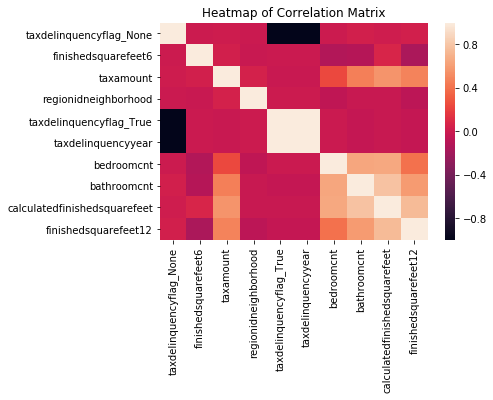

In [24]:
imp_columns = imp_features.col_labels.tolist()
corr_df=train_merge[imp_columns]

corr=corr_df.corr()
corr = (corr)
sns.heatmap(corr, xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.title('Heatmap of Correlation Matrix')
corr

From the heat map above, we can see high intercorrelation among independant variables. This is sign of multicollinearity in the data, which will affect the statistical inferences made about the data.

'logerror' is the target variable for our prediction. So lets analyze this.

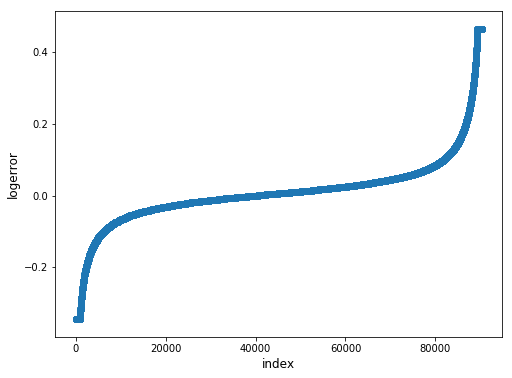

In [25]:
plt.figure(figsize=(8,6))
plt.scatter(range(train_merge.shape[0]), np.sort(train_merge.logerror.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('logerror', fontsize=12)
plt.show()

Scatter plot for the dependent variable shows there are outliers in the data. Lets plot the histogram to visualize the distribution.

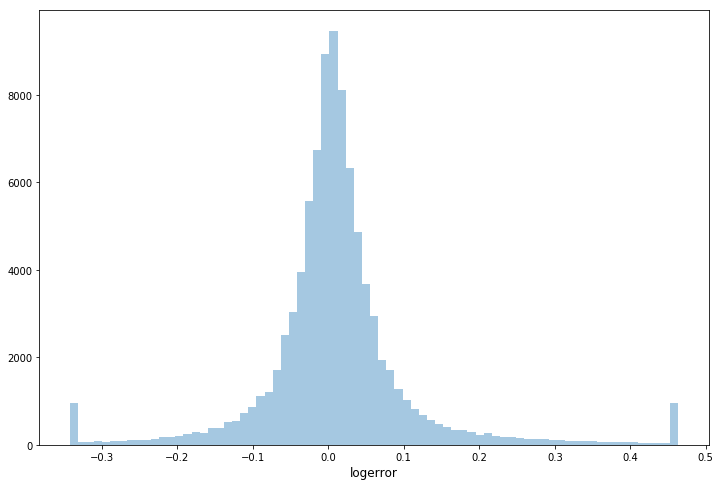

In [26]:

plt.figure(figsize=(12,8))
sns.distplot(train_merge.logerror.values, bins=75, kde=False)
plt.xlabel('logerror', fontsize=12)
plt.show()

'logerror' is normally distributed.

#### Finished SquareFeet 12:

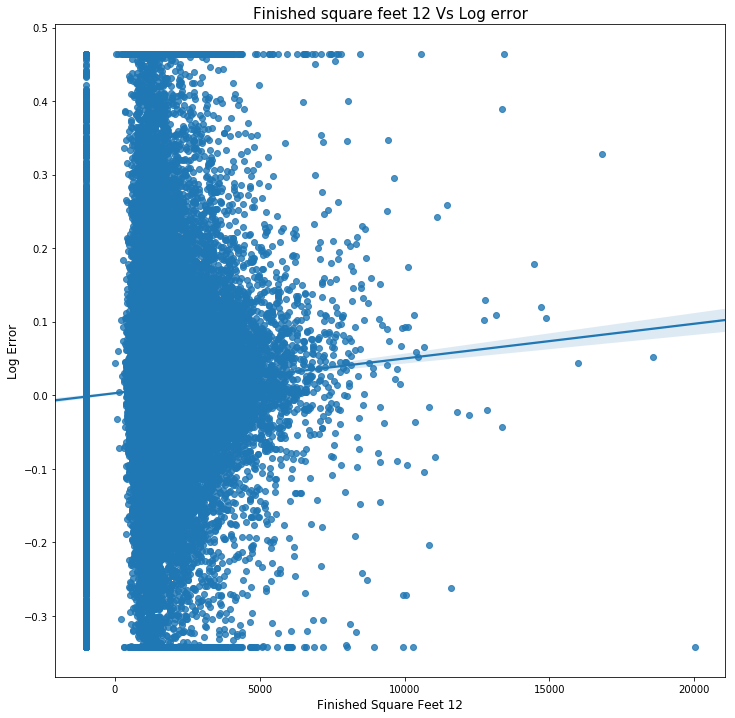

In [27]:
plt.figure(figsize=(12,12))
sns.regplot(x="finishedsquarefeet12", y="logerror", data=train_merge)
plt.ylabel('Log Error', fontsize=12)
plt.xlabel('Finished Square Feet 12', fontsize=12)
plt.title("Finished square feet 12 Vs Log error", fontsize=15)
plt.show()

Range of logerror narrows down with increase in finishedsquarefeet12 variable

#### calculatedfinishedsquarefeet

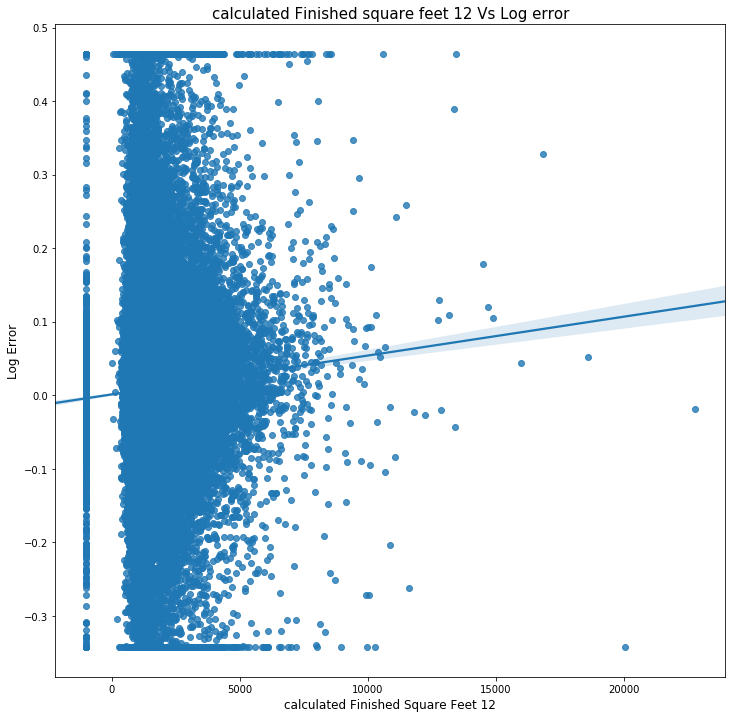

In [28]:
plt.figure(figsize=(12,12))
sns.regplot(x="calculatedfinishedsquarefeet", y="logerror", data=train_merge)
plt.ylabel('Log Error', fontsize=12)
plt.xlabel('calculated Finished Square Feet 12', fontsize=12)
plt.title("calculated Finished square feet 12 Vs Log error", fontsize=15)
plt.show()

Range of logerror narrows down with increase in finishedsquarefeet12 variable, which is similar to the above plot.

#### bathroomcnt

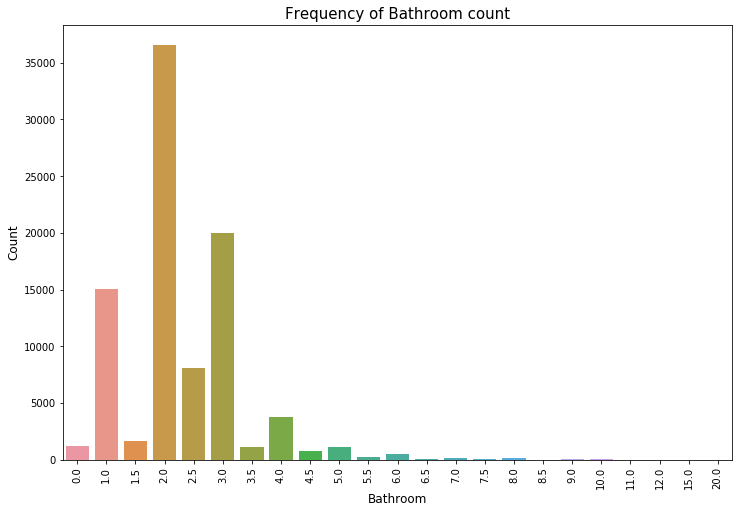

In [29]:
plt.figure(figsize=(12,8))
sns.countplot(x="bathroomcnt", data=train_merge)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Bathroom', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Bathroom count", fontsize=15)
plt.show()

Most of the houses have 2 bathrooms. 

#### bedroomcnt

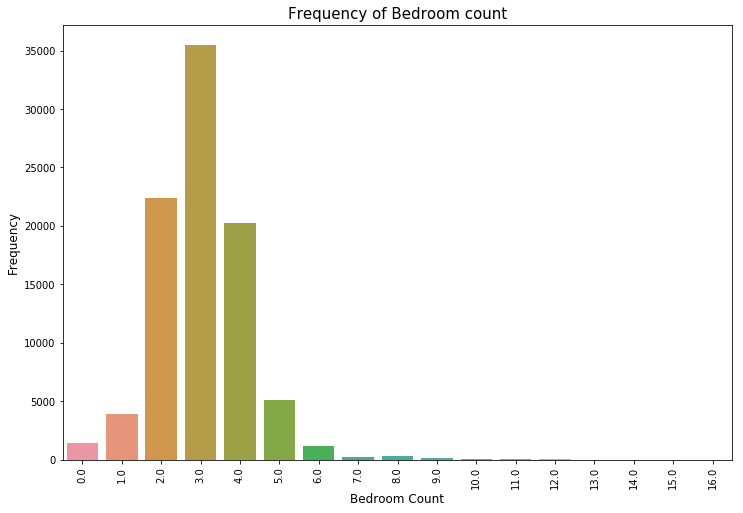

In [30]:
plt.figure(figsize=(12,8))
sns.countplot(x="bedroomcnt", data=train_merge)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Bedroom Count', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Bedroom count", fontsize=15)
plt.show()

We have amximum number od houses with bedroom=3

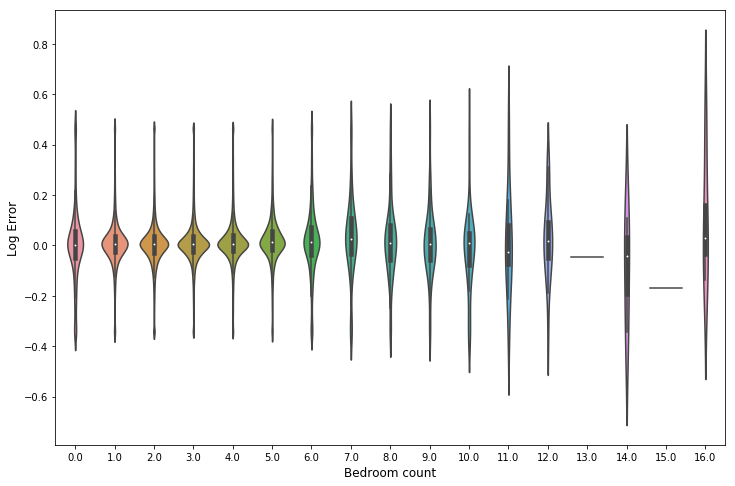

In [31]:

plt.figure(figsize=(12,8))
sns.violinplot(x='bedroomcnt', y='logerror', data=train_merge)
plt.xlabel('Bedroom count', fontsize=12)
plt.ylabel('Log Error', fontsize=12)
plt.show()

The outliers here are making things a bit squished.Distribution is centered around the mean for bedroom counts 0-5. Bedroom count distribution is decreasing as the count increases.

#### Yearbuilt

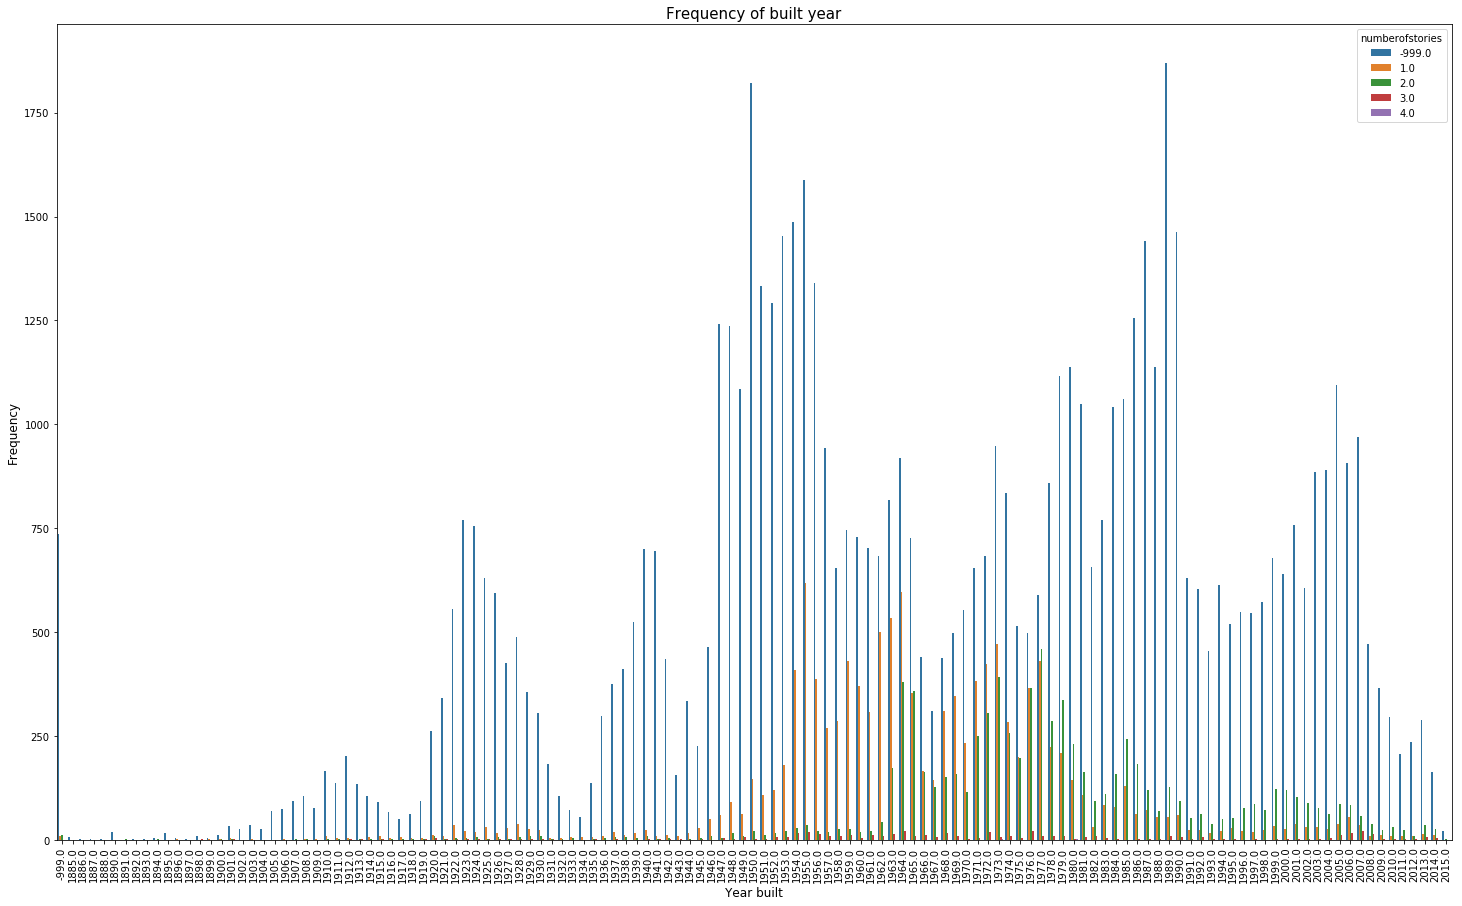

In [32]:
plt.figure(figsize=(25,15))
sns.countplot(x="yearbuilt", data=train_merge,hue='numberofstories')
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Year built', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of built year", fontsize=15)
plt.show()


The count plot is dense between 1946-1990.It looks like there is sudden increase in double storied buildings between 1963-1981. Heighest number of houses were built on the year 1955.

### Time to Train the Model

In [33]:
X_train = train_merge[train_features]
y_train = train_merge.logerror
print(X_train.shape, y_train.shape)



(90275, 40) (90275,)


In [34]:
sample['parcelid'] = sample['ParcelId']
test_merge = sample.merge(properties, on='parcelid', how='left')
for c in cat_feature_inds:
    dummy=pd.get_dummies(test_merge[c],prefix=c)
    test_merge=pd.concat([test_merge,dummy],axis=1)
test_merge.drop(['hashottuborspa', 'fireplaceflag', 'taxdelinquencyflag'],axis=1,inplace=True)

x_test = test_merge[train_features]
y_train=train_merge.logerror

In [35]:
X_train.fillna(-999,inplace=True)
x_test.fillna(-999,inplace=True)

In [36]:
X = train_merge[train_features]
y = train_merge.logerror
print(X_train.shape, y_train.shape)


(90275, 40) (90275,)


In [37]:

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
                    
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)

dump_svmlight_file(X_train, y_train, 'dtrain.svm', zero_based=True)
dump_svmlight_file(X_valid, y_valid, 'dvalid.svm', zero_based=True)
dtrain_svm = xgb.DMatrix('dtrain.svm')
dvalid_svm = xgb.DMatrix('dvalid.svm')
                   
                    
param = {
    'max_depth': 3,  # the maximum depth of each tree
    'eta': 0.3,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'reg:linear'
    #'num_class': 3
}
# the number of classes that exist in this datset
num_round = 20

bst = xgb.train(param, dtrain, num_round)

In [40]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
                    
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)


# Construct some pipelines
pipe_lr = Pipeline([('scl', StandardScaler()),
         ('clf', LinearRegression())])


pipe_rf = Pipeline([('scl', StandardScaler()),
                ('clf', RandomForestRegressor(random_state=42))])

xgb_pipeline = Pipeline([("scl", StandardScaler()), 
                        ("clf",xgb.XGBRegressor())])

# Construct grid searches
jobs = -1


# Set grid search params
#bstrap=[True, False]
grid_param_rf = {# Number of trees in random forest
                'clf__n_estimators': [int(x) for x in np.linspace(start = 100, stop = 200, num = 12)],
                # Number of features to consider at every split
                'clf__max_features': ['auto', 'sqrt'],
                # Maximum number of levels in tree
                'clf__max_depth' : [int(x) for x in np.linspace(5, 30, num = 6)],
                #max_depth.append(None)
                # Minimum number of samples required to split a node
                'clf__min_samples_split' : np.arange(2, 5, 10),
                # Minimum number of samples required at each leaf node
                'clf__min_samples_leaf' : np.arange(1, 2, 4)
                # Method of selecting samples for training each tree
                #'bootstrap' : bstrap
}

grid_param_XGB = {
    'max_depth': 3,  # the maximum depth of each tree
    'eta': 0.3,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'reg:linear'
    #'num_class': 3
}


gs_rf = RandomizedSearchCV(estimator=pipe_rf,
             param_distributions=grid_param_rf,
             n_iter = 25, cv = 3, verbose=2, random_state=42, n_jobs = -1)



# List of pipelines for ease of iteration
grids = [pipe_lr,gs_rf,xgb_pipeline]

# Dictionary of pipelines and classifier types for ease of reference
grid_dict = {0: 'Linear Regression', 
        1: 'Random Forest', 2: 'XGBoost'}


# Fit the grid search objects
print('Performing model optimizations...')
best_acc = 0.0
best_clf = 0
best_gs = ''
for idx, gs in enumerate(grids):
    print('\nEstimator: %s' % grid_dict[idx])
    # Fit grid search
    if grids=='xgb_pipeline':
        gs.train(grid_param_XGB, dtrain, num_round)
    else:
        gs.fit(X_train, y_train)
    y_test = gs.predict(x_test)
    y_test = pd.DataFrame(y_test)
    y_test[1] = y_test[0]
    y_test[2] = y_test[0]
    y_test[3] = y_test[0]
    y_test[4] = y_test[0]
    y_test[5] = y_test[0] 
    y_test.columns = ["201610","201611","201612","201710","201711","201712"]
    submission = y_test.copy()
    submission["parcelid"] = sample["ParcelId"].copy()
    cols = ["parcelid","201610","201611","201612","201710","201711","201712"]
    201610, 201611, 201612, 201701, 201702, 201703
    submission = submission[cols]
    filename = "Prediction_" + str(submission.columns[0]) + re.sub("[^0-9]", "",str(datetime.datetime.now())) + '.csv'
    print(filename)
    submission.to_csv(filename,index=False)

 


Performing model optimizations...

Estimator: Linear Regression
Prediction_parcelid20180816140236031770.csv

Estimator: Random Forest
Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 16.3min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 39.2min finished


Prediction_parcelid20180816144650950162.csv

Estimator: XGBoost
Prediction_parcelid20180816144816979750.csv
